In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from cvxpy import *
import random
import svt_solver
from sklearn.utils.extmath import randomized_svd, svd_flip
from scipy.sparse.linalg import svds
import pmf_solver
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

## Data Preprocessing

In [3]:
data = loadmat("adjdata.mat")
adj_mat = data['adj_aveROI']
adj_mat_flat = adj_mat.flatten()

In [4]:
# create a dataframe that is 1540 * 49 the combination of every two ROIs
def data_cleaning(X):
#     ''''
#     This funciton flattens each participant adj matrix into a column vector,
#     and concatenate together. 
#     Rows with no observed entries were removed.
#     ''''
    
    rows = X[0].shape[0]
    cols = X[0].shape[1]
    sub_num = X.shape[0]
    df_col = int(rows * cols / 2 - rows / 2)
    df = np.empty([0,df_col])
    col_name = []

    for subject in range(sub_num):
        sub_vec = []
        for i in range(rows):
            for j in range(cols):
                if i > j:
                    sub_vec.append(X[subject][i][j])
                    #col_name.append(str(i)+ "&" + str(j))
        sub_vec = np.array(sub_vec)
        df = (np.vstack((df,sub_vec)))
    for i in range(rows):
        for j in range(cols):
            if i > j:    
                col_name.append(str(i)+ "&" + str(j))
    
    empty_col = [col_name[i] for i in range(df_col) if np.isnan(df[:,i]).all() == True]
    empty_col_idx = [i for i in range(df_col) if np.isnan(df[:,i]).all() == True]
    for name in empty_col:
        col_name.remove(name)
    
    df_cleaned = np.delete(df, empty_col_idx, 1)
    df_cleaned = np.transpose(df_cleaned)
    missing_rate = np.sum(np.isnan(df_cleaned) == True) / (df_cleaned.shape[0] * df_cleaned.shape[1])

    print(f"Data dimension:{df_cleaned.shape}, missing rate:{missing_rate}")
    return df_cleaned, col_name

In [5]:
flatten_mat, col_name = data_cleaning(adj_mat_flat)

Data dimension:(1540, 49), missing rate:0.7344420885237212


### Problem set-up, omega, omega_mask

In [6]:
def get_omege(X):
    m = X.shape[0]
    n = X.shape[1]
    omega = np.zeros([m,n])
    omega_mask = np.zeros([m,n])
    for i in range(m):
        for j in range(n):
            if np.isnan(X[i][j]):
                omega[i][j] = 0
                omega_mask[i][j] = 0
            else:
                omega[i][j] = X[i][j]
                omega_mask[i][j] = 1
    return omega, omega_mask

In [7]:
omega_list = []
omega_mask_list = []
for sub in adj_mat[0]:
    omega, omega_mask = get_omege(sub)
    omega_list.append(omega)
    omega_mask_list.append(omega_mask)

### Get missing rate

In [8]:
def get_missing_rate(omega):
    count = 0
    flatten = omega.flatten()
    for entry in flatten:
        if entry == 0:
            count += 1
    return count / len(flatten)

In [9]:
missing_rate = []
for o in omega_list:
    curr = get_missing_rate(o)
    missing_rate.append(curr)

Text(0.5, 1.0, 'Missing Rate')

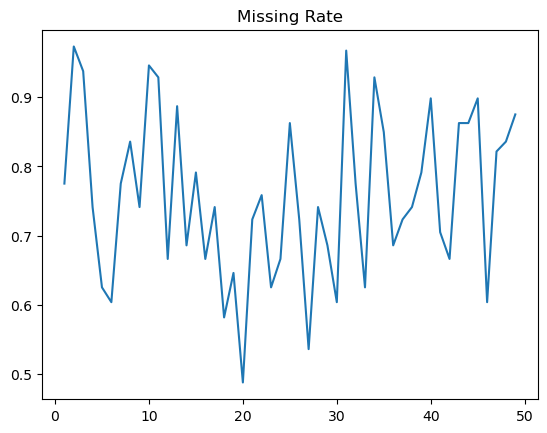

In [32]:
plt.plot(range(1,50), missing_rate)
plt.title('Missing Rate')
plt.xlabel()

<function matplotlib.pyplot.show(close=None, block=None)>

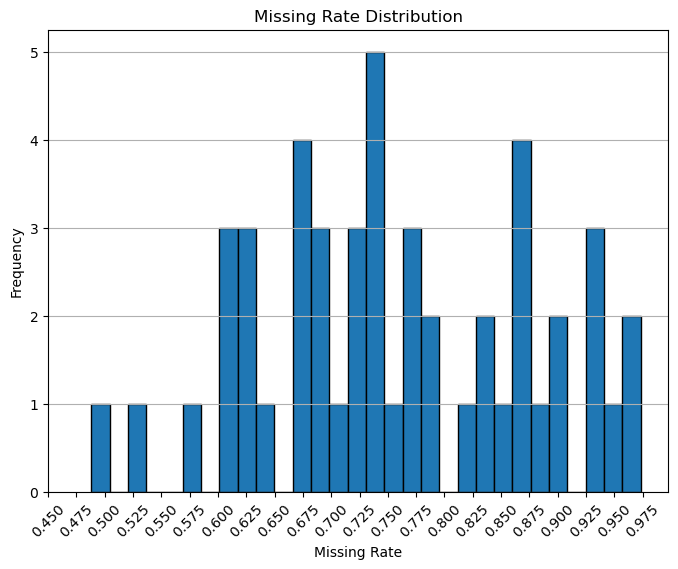

In [105]:
plt.figure(figsize=(8, 6))
plt.hist(missing_rate, bins=30, edgecolor='black')
plt.xticks(np.arange(0.45, 1.00, 0.025), rotation=45)
plt.title("Missing Rate Distribution")
plt.xlabel("Missing Rate")
plt.ylabel("Frequency")

plt.grid(True, axis='y')

plt.show

In [31]:
pds = pd.Series(missing_rate)
pds.describe()

count    49.000000
mean      0.756861
std       0.120090
min       0.488109
25%       0.666468
50%       0.741379
75%       0.862663
max       0.973246
dtype: float64

In [114]:
adj_mat.shape[1]

49

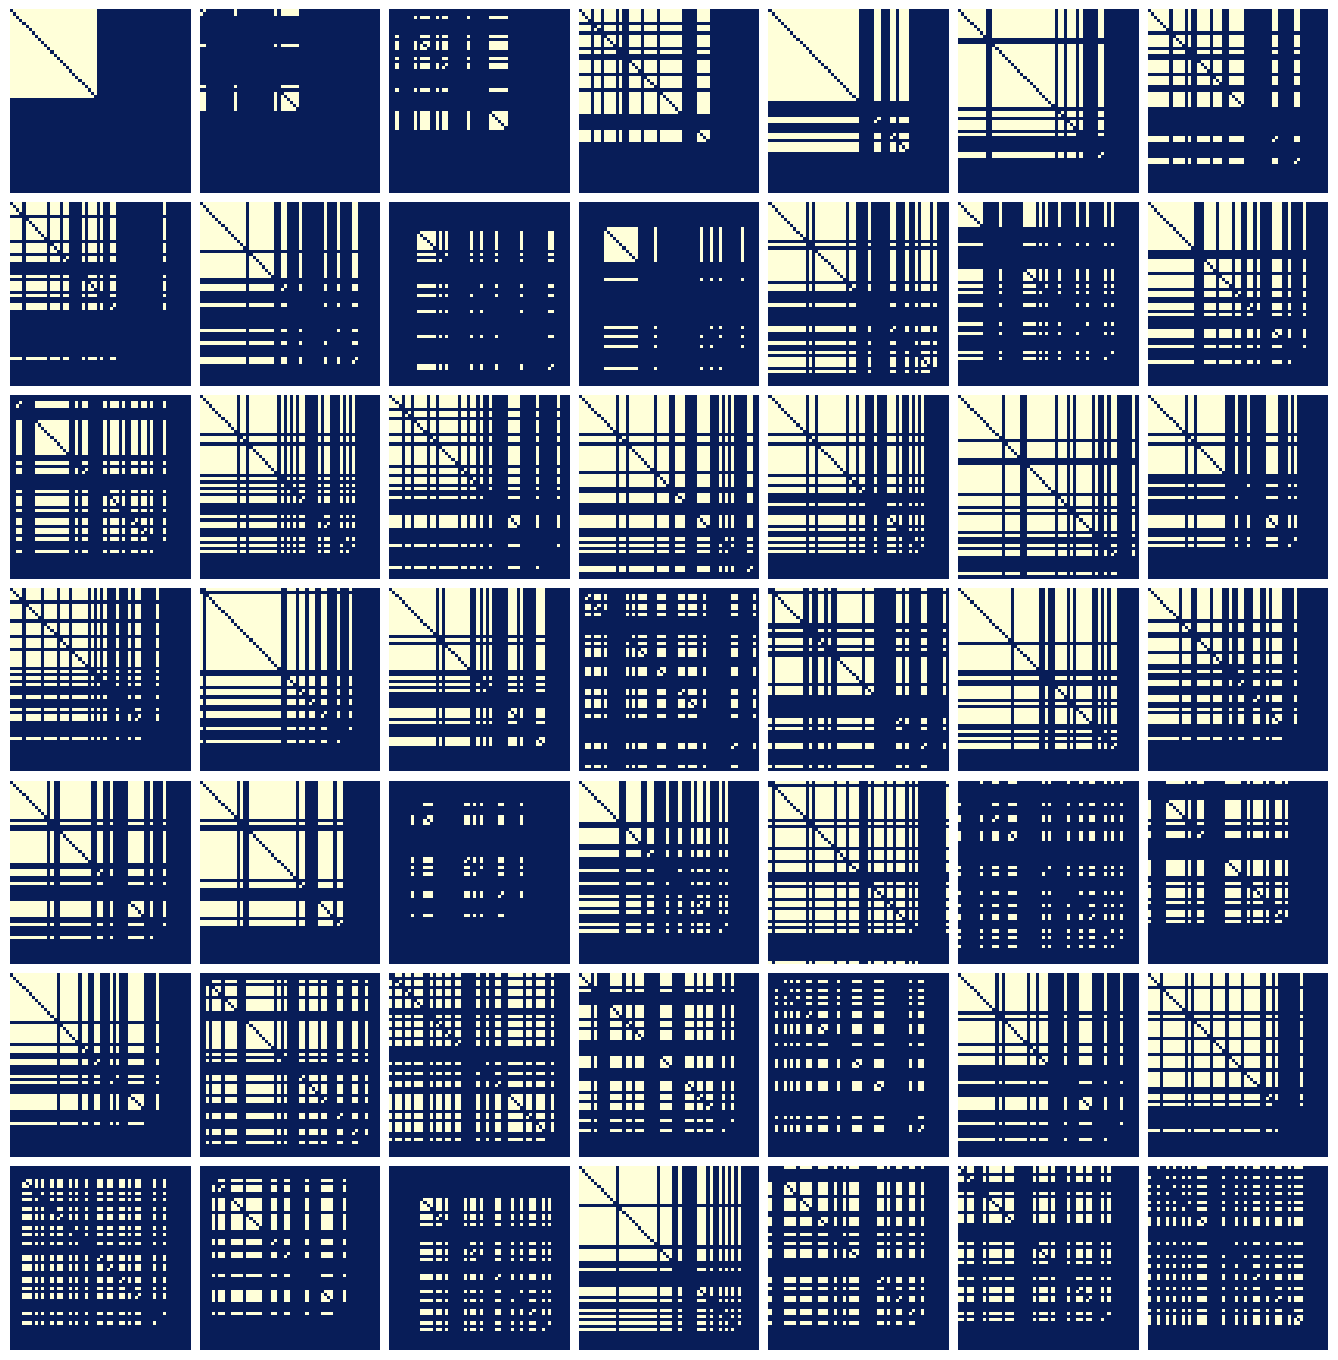

In [142]:
fig, axes = plt.subplots(7, 7, figsize=(14, 14))
fig.tight_layout()
# cbar_ax = fig.add_axes([0.96, 0.1, 0.02, 0.8])cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])

# dummy_heatmap = sns.heatmap(np.zeros((1, 1)), cmap='YlGnBu', cbar=False, ax=cbar_ax)

for i, ax in enumerate(axes.flat):
    matrix = adj_mat[0][i]
    missing_matrix = np.isnan(matrix).astype(int)

#     ax.imshow(missing_matrix, cmap='binary', aspect='auto')
    sns.heatmap(missing_matrix, cmap='YlGnBu', cbar=False, ax=ax)
#     ax.set_title(f'Subject {i+1}', fontsize=10, pad=3)
    ax.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust the spacing between subplots

plt.show()

### Nuclear Norm Minimization
This section used NNM to complete all c_k. Errors are calculated using either frobenius norm or leave-one-out cross validation. 

In [11]:
def nuclear_norm_solve(A, mask, mu=1.0):
    X = Variable(shape=A.shape)
    objective = Minimize((mu * norm(X, "nuc")) + sum_squares(multiply(mask, X-A)))
    problem = Problem(objective, [])
    problem.solve(solver=SCS, eps=1e-8)
    return X.value

#### Baseline: randomly fill missing entries.

In [12]:
baseline = []
baseline_error = []
observed_percent = 0.1

for i in range(len(omega_list)):
    num_rows, num_cols = omega_list[i].shape
    observed_indices = np.nonzero(omega_mask_list[i])
    num_observed_entries = len(observed_indices[0])
    num_entries_to_extract = int(num_observed_entries * observed_percent)
    
#     for ite in range(10):
    selected_indices = np.random.choice(num_observed_entries, size=num_entries_to_extract, replace=False)

    filled_matrix = np.copy(omega_list[i])
    random_values = np.random.random(size=num_entries_to_extract)
    filled_matrix[observed_indices[0][selected_indices], observed_indices[1][selected_indices]] = random_values

    baseline.append(filled_matrix)

    ori = omega_list[i][observed_indices[0][selected_indices], observed_indices[1][selected_indices]]
    filled = filled_matrix[observed_indices[0][selected_indices], observed_indices[1][selected_indices]]

    errors = mean_squared_error(ori, filled)
    modified_mse = errors * num_entries_to_extract

    baseline_error.append(modified_mse)

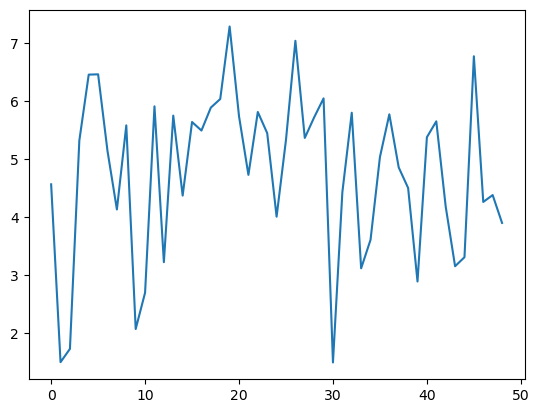

In [13]:
plt.plot(range(len(omega_list)), np.sqrt(baseline_error))

#### NNM algorithm, calculate errors with frobenius norm.

In [14]:
NNM_hat = []
for i in range(len(omega_list)):
    sub_hat = nuclear_norm_solve(omega_list[i], omega_mask_list[i])
    NNM_hat.append(sub_hat) 

In [15]:
NNM_error = []
for i in range(len(omega_list)):
    
    observed_index = np.nonzero(omega_mask_list[i])
    observed_entries = omega_list[i][observed_index]
    completed_entries = NNM_hat[i][observed_index]
    
    error = np.linalg.norm(observed_entries - completed_entries) / np.linalg.norm(observed_entries)
    NNM_error.append(error)

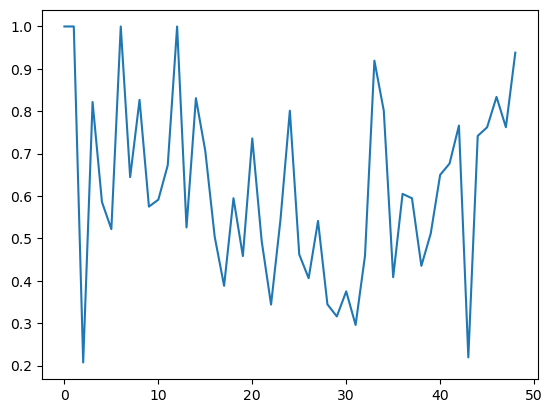

In [16]:
plt.plot(range(len(omega_list)), NNM_error)

In [17]:
test_percent = 0.1
NNM_loo = []

for i in range(len(omega_list)):
    num_rows, num_cols = omega_list[i].shape
    
    # Find the indices of observed entries (non-zero values)
    observed_indices = np.nonzero(omega_list[i])
    
    # Split the observed indices into training and testing sets
    total_mse = 0
    for i in range(10):
        train_indices, test_indices = train_test_split(np.arange(len(observed_indices[0])), test_size=test_percent)

        train_matrix = np.copy(omega_list[i])
        train_matrix[observed_indices[0][test_indices], observed_indices[1][test_indices]] = 0

        completed_omega = nuclear_norm_solve(train_matrix, omega_mask_list[i], mu=1.0)

#         observed_entries = omega_list[i][observed_indices]
#         completed_entries = completed_omega[observed_indices]
        
        test_entries = omega_list[i][observed_indices[0][test_indices], observed_indices[1][test_indices]]
        test_pred = completed_omega[observed_indices[0][test_indices], observed_indices[1][test_indices]]

        # Calculate the mean squared error (MSE) between the completed entries and the original entries
        mse = mean_squared_error(test_entries, test_pred)
        modified_mse = mse*len(test_indices)
        total_mse += modified_mse
        
#     mse = total_mse / 10
    NNM_loo.append(total_mse)

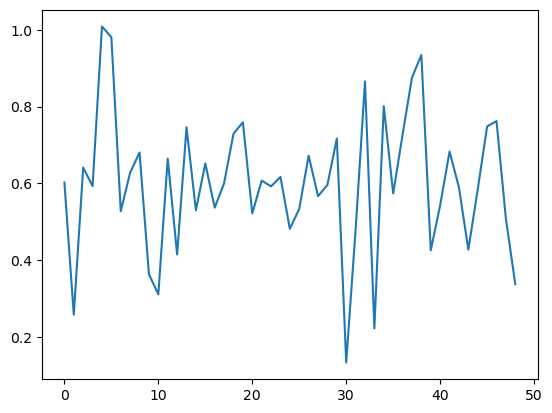

In [18]:
plt.plot(range(len(omega_list)), np.sqrt(NNM_loo))

In [19]:
df_baseline = pd.DataFrame(np.sqrt(baseline_error * 10), columns=['error'])
df_baseline['measure'] = "baseline"
df_NNM_fro = pd.DataFrame(NNM_error, columns=['error'])
df_NNM_fro['measure'] = "frobenius norm"
df_NNM_loo = pd.DataFrame(np.sqrt(NNM_loo * 10), columns=['error'])
df_NNM_loo['measure'] = "loo"

df_NNM = pd.concat([df_baseline, df_NNM_fro, df_NNM_loo])
df_NNM['group'] = 'NNM'

<Axes: xlabel='measure', ylabel='error'>

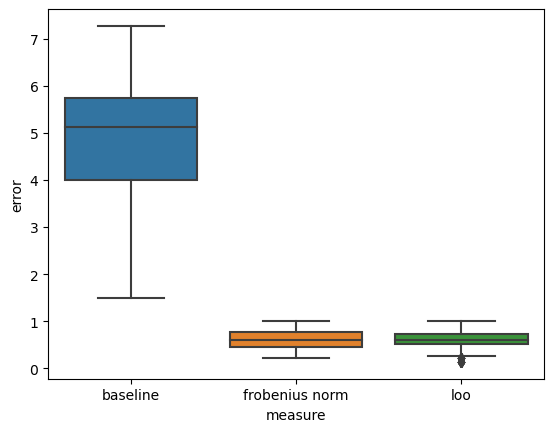

In [20]:
sns.boxplot(data=df_NNM, x='measure', y='error')

### Alternating least squares

#### ALS is used, errors are measured by frobenius norm.

In [21]:
ALS_hat = []
for i in range(len(omega_list)):
    sub_hat = pmf_solver.pmf_solve(omega_list[i], omega_mask_list[i], 3, .5)
    ALS_hat.append(sub_hat)

In [22]:
ALS_error = []
for i in range(len(omega_list)):
    
    observed_index = np.nonzero(omega_mask_list[i])
    observed_entries = omega_list[i][observed_index]
    completed_entries = ALS_hat[i][observed_index]
    
    error = np.linalg.norm(observed_entries - completed_entries) / np.linalg.norm(observed_entries)
    ALS_error.append(error)

#### Leave-one-out CV

In [23]:
test_percent = 0.1
ALS_loo = []

# Iterate over each matrix
for i in range(len(omega_list)):
    num_rows, num_cols = omega_list[i].shape
    observed_indices = np.nonzero(omega_list[i])

    total_mse = 0
    for i in range(10):
        train_indices, test_indices = train_test_split(np.arange(len(observed_indices[0])), test_size=test_percent)
        train_matrix = np.copy(omega_list[i])
        train_matrix[observed_indices[0][test_indices], observed_indices[1][test_indices]] = 0

        completed_omega = pmf_solver.pmf_solve(train_matrix, omega_mask_list[i], 3, .5)
#         observed_entries = omega_list[i][observed_indices]
#         completed_entries = completed_omega[observed_indices]
        
        test_entries = omega_list[i][observed_indices[0][test_indices], observed_indices[1][test_indices]]
        test_pred = completed_omega[observed_indices[0][test_indices], observed_indices[1][test_indices]]
        
        mse = mean_squared_error(test_entries, test_pred)
        modified_mse = mse*len(test_indices)
        total_mse += modified_mse
        
    ALS_loo.append(total_mse)

In [24]:
df_baseline = pd.DataFrame(np.sqrt(baseline_error * 10), columns=['error'])
df_baseline['measure'] = "baseline"
df_ALS_fro = pd.DataFrame(ALS_error, columns=['error'])
df_ALS_fro['measure'] = "frobenius norm"
df_ALS_loo = pd.DataFrame(np.sqrt(ALS_loo), columns=['error'])
df_ALS_loo['measure'] = "loo"

df_ALS = pd.concat([df_baseline, df_ALS_fro, df_ALS_loo])
df_ALS['group'] = 'ALS'

<Axes: xlabel='measure', ylabel='error'>

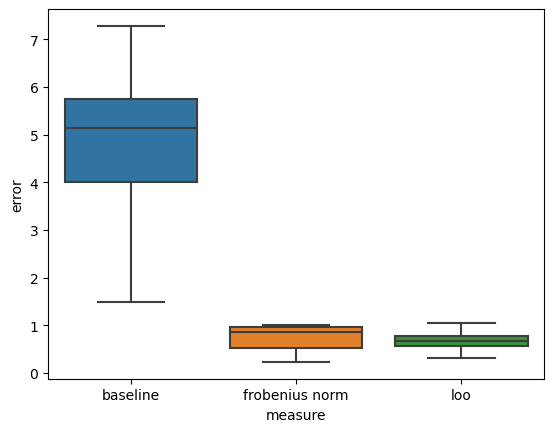

In [25]:
sns.boxplot(data=df_ALS, x='measure', y='error')

In [26]:
total_df = pd.concat([df_NNM, df_ALS])

<Axes: xlabel='group', ylabel='error'>

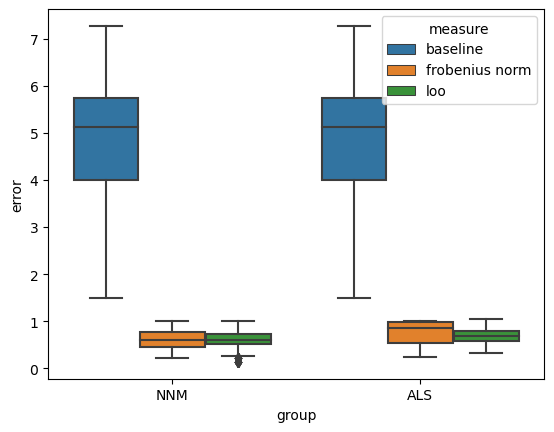

In [27]:
sns.boxplot(data=total_df, x='group', y='error', hue='measure')

### Find the rank distribution of completed matrix

In [109]:
rank_NNM = []
for i in range(len(NNM_hat)):
    m = NNM_hat[i]
    U,S,Vh = np.linalg.svd(m)
    for j in range(len(S)):
        if j == 1:
            continue
        elif S[j-1] / S[j] > 100:
            rank_NNM.append(j-1)

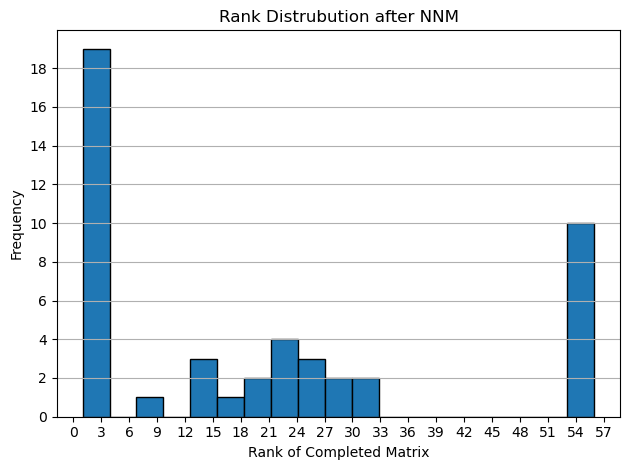

In [110]:
plt.hist(rank_NNM, bins = 19, edgecolor='black')
plt.title('Rank Distrubution after NNM')
plt.xlabel('Rank of Completed Matrix')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 58, 3))
plt.yticks(np.arange(0, 20, 2))
plt.grid(True, axis='y')

plt.tight_layout()

plt.show()

In [111]:
rank_ALS = []
for i in range(len(ALS_hat)):
    m = NNM_hat[i]
    U,S,Vh = np.linalg.svd(m)
    for j in range(len(S)):
        if j == 1:
            continue
        elif S[j-1] / S[j] > 100:
            rank_ALS.append(j-1)

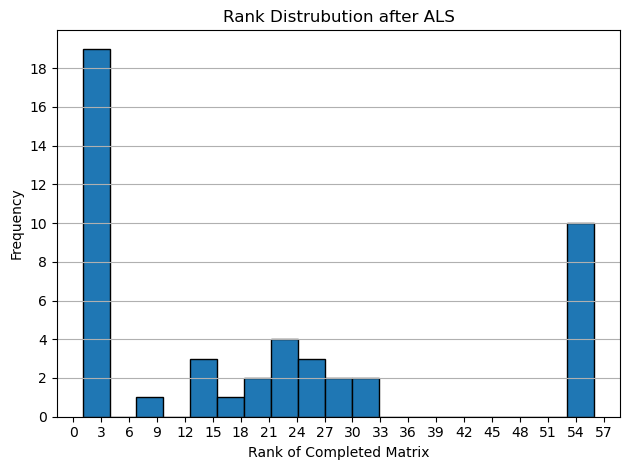

In [112]:
plt.hist(rank_ALS, bins = 19, edgecolor='black')
plt.title('Rank Distrubution after ALS')
plt.xlabel('Rank of Completed Matrix')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 58, 3))
plt.yticks(np.arange(0, 20, 2))
plt.grid(True, axis='y')

plt.tight_layout()

plt.show()

### SVT

In [15]:
# # rmse_list_SVT = []
# sub_list = []
# SVT_hat = []
# for i in range(len(omega_list)):
#     sub_mat = adj_mat[0][i]
#     if missing_rate[i] >= 0.8:
#         continue
#     else:
#         sub_hat = svt_solver.svt_solve(omega_list[i], omega_mask_list[i])
#         SVT_hat.append(sub_hat)
#         sub_list.append(i)

In [16]:
# SVT_error = []
# for i in range(len(sub_list)):
#     error = np.linalg.norm(omega_list[i] - SVT_hat[i])
#     SVT_error.append(error)

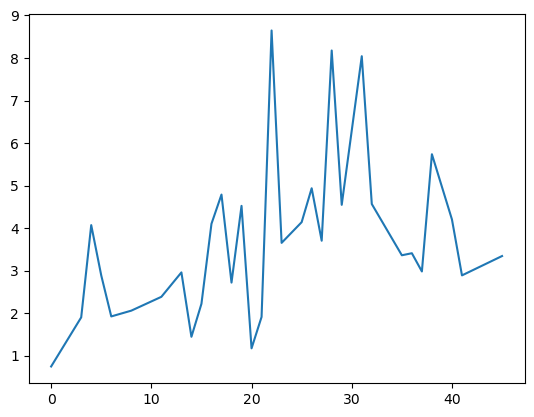

In [17]:
# plt.plot(sub_list, SVT_error)

### Observed entries for specific ROI

In [ ]:
sub_num = adj_mat.shape[0]
ROI_num = adj_mat[0].shape[0]

ROI_sub_mat = np.zeros([sub_num, ROI_num])
for sub in range(sub_num):
    for i in range(ROI_num):
        for j in range (ROI_num):
            if i < j and np.isnan(adj_mat[sub][i][j]) == False :
                ROI_sub_mat[sub][i] = 1
                ROI_sub_mat[sub][j] = 1

ROI_sub_mat = np.transpose(ROI_sub_mat)

In [ ]:
one_locations = ROI_sub_mat == 1
plt.figure(figsize=(5, 30))
plt.imshow(one_locations, cmap='binary')
plt.title('One Locations')
plt.show()

### The overview of missing data locations

In [ ]:
missing_mask = np.isnan(X)
x_coords, y_coords = np.where(missing_mask)
plt.figure(figsize=(12, 20))
plt.scatter(y_coords, x_coords, marker='x', color='red')
plt.xlabel('Subject')
plt.ylabel('ROI Combination')
plt.title('Missing Data Positions')
plt.xticks(np.arange(0,49))
plt.grid(True)
plt.show()

### Every 100 ROI combinations missing data pattern

In [ ]:
for m in range(1,16):
    missing_mask = np.isnan(X[(m-1)*100:m*100,:])
    missing_rate = np.sum(np.isnan(X[(m-1)*100:m*100,:]) == True) / (X[(m-1)*100:m*100,:].shape[0] * X[(m-1)*100:m*100,:].shape[1])
    x_coords, y_coords = np.where(missing_mask)
    plt.figure(figsize=(12, 20))
    plt.scatter(y_coords, x_coords, marker='x', color='red')
    plt.xlabel('Subject')
    plt.ylabel(f"{(m-1)*100 + 1} to {m*100} ROI Combinations")
    plt.title(f"Missing Data Positions, missing rate: {missing_rate*100:.2f}%")
    plt.xticks(np.arange(0,49), rotation=45)
    plt.yticks(range(100), col_name[(m-1)*100:m*100])
    plt.grid(True)
    plt.show()

missing_mask = np.isnan(X[1501:1541,:])
missing_rate = np.sum(np.isnan(X[1501:1541,:]) == True) / (X[1501:1541,:].shape[0] * X[1501:1541,:].shape[1])
x_coords, y_coords = np.where(missing_mask)
plt.figure(figsize=(12, 12))
plt.scatter(y_coords, x_coords, marker='x', color='red')
plt.xlabel('Subject')
plt.ylabel(f"1501 to 1540 ROI Combinations")
plt.title(f"Missing Data Positions, missing rate: {missing_rate*100:.2f}%")
plt.xticks(np.arange(0,49), rotation=45)
plt.yticks(range(39), col_name[1501:1541])
plt.grid(True)
plt.show()